# 데이터 불러오기

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_7.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 30:
        row_5h = group.iloc[29]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

(25, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,RU,RUVVO,0359a9fc-db7a-3187-9550-f9a3b3c90f37,2024-08-20 14:20:00,19.800000,17.000000,35.995215,129.905310,RUVVO,7,1
1,RU,RUNJK,060db0be-c97f-3f11-8304-c637fe4fa4d5,2024-10-16 19:20:00,23.600000,25.000000,35.849305,129.874628,RUNJK,7,0
2,RU,RUVVO,06912aab-4dd2-319e-b14f-6766b17d0d72,2024-09-15 04:50:00,45.801935,42.819355,34.949261,129.303834,RUVVO,7,1
3,RU,RUVVO,091a653d-139a-33db-8f6d-2b5b389022d0,2024-10-31 14:20:00,40.800000,44.000000,35.954560,130.283743,RUVVO,7,1
4,RU,RUVVO,1efac1d5-4f2a-3fef-917e-a9f480f0853b,2024-07-17 13:30:00,204.415862,203.117241,35.030499,129.098940,RUVVO,7,1


PORT_NAME
RUVVO    21
RUNJK     4
Name: count, dtype: int64

## XGBoost

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

# ===== 데이터 분할 =====
X = df_5h[["LAT", "LON", "COG", "HEADING"]]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== XGBoost 모델 정의 =====
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# ===== 학습 =====
xgb.fit(X_train, y_train)

# ===== 교차검증 =====
acc_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1_macro')

# ===== 평가 =====
train_score = xgb.score(X_train, y_train)
test_score = xgb.score(X_test, y_test)
gap = train_score - test_score

print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"CV Accuracy Mean: {acc_scores.mean():.4f}")
print(f"CV F1 Macro: {f1_scores.mean():.4f}")
print(f"과적합 Gap: {gap:.4f}")
if gap > 0.1:
    print("⚠️ 과적합 의심 있음")
else:
    print("✅ 과적합 위험 없음")

# ===== 분류 리포트 =====
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


Train Accuracy: 0.8500
Test Accuracy: 0.8000
CV Accuracy Mean: 0.8500
CV F1 Macro: 0.6571
과적합 Gap: 0.0500
✅ 과적합 위험 없음
              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



## RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# ===== 데이터 준비 =====
X = df_5h[["LAT", "LON", "COG", "HEADING"]]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 모델 정의 (과적합 방지용 설정) =====
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# ===== 학습 =====
rf.fit(X_train, y_train)

# ===== 교차검증 =====
acc_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro')

# ===== 성능 비교 =====
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
gap = train_score - test_score

print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"CV Accuracy Mean: {acc_scores.mean():.4f}")
print(f"CV F1 Macro: {f1_scores.mean():.4f}")
print(f"과적합 Gap: {gap:.4f}")
if gap > 0.1:
    print("⚠️ 과적합 의심 있음")
else:
    print("✅ 과적합 위험 없음")

# ===== 리포트 출력 =====
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


Train Accuracy: 1.0000
Test Accuracy: 0.8000
CV Accuracy Mean: 0.7500
CV F1 Macro: 0.6190
과적합 Gap: 0.2000
⚠️ 과적합 의심 있음
              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



## LightGBM

In [6]:
# ===== 1. 라이브러리 import =====
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier


# ===== 3. 특성과 라벨 설정 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]

# ===== 4. 라벨 인코딩 =====
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 5. 학습/테스트 데이터 분할 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# ===== 6. LightGBM 모델 정의 및 학습 =====
lgb_model = LGBMClassifier(
    is_unbalance=True,   # 클래스 불균형 자동 보정
    n_estimators=50,     # 트리 개수 줄이기
    n_jobs=-1,           # 병렬 처리
    random_state=42
)
lgb_model.fit(X_train, y_train)

# ===== 7. 예측 및 성능 평가 =====
y_pred = lgb_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 14, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.823529 -> initscore=1.540445
[LightGBM] [Info] Start training from score 1.540445
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 소수데이터에 가중치 + XGBoost

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]

# ===== 4. 라벨 인코딩 =====
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 5. 학습/테스트 분할 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 6. 클래스별 가중치 계산 =====
class_counts = np.bincount(y_train)
total = sum(class_counts)
class_weights = {i: total / c for i, c in enumerate(class_counts)}
sample_weights = np.array([class_weights[label] for label in y_train])

# ===== 7. XGBoost 모델 학습 =====
xgb_model = XGBClassifier(
    n_estimators=50,            # 트리 개수
    max_depth=5,                # 트리 깊이 제한
    n_jobs=-1,                  # 병렬 처리
    use_label_encoder=False,    # 경고 제거
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# ===== 8. 예측 및 성능 평가 =====
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.75      0.75      0.75         4

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5



C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Soft Voting - RandomForest, XGBoost 사용

In [10]:
# 기본 라이브러리
import pandas as pd
import numpy as np

# 전처리 및 분할
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 분류 모델들
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# 평가 지표
from sklearn.metrics import classification_report


# 개별 모델 재정의 (최적 파라미터 기반)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train, sample_weight=sample_weights)

# 예측 및 평가
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sk

## ✅ Oversampling + XGBoost + RandomForest

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       RUNJK       0.83      1.00      0.91         5
       RUVVO       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9



C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\xgbo

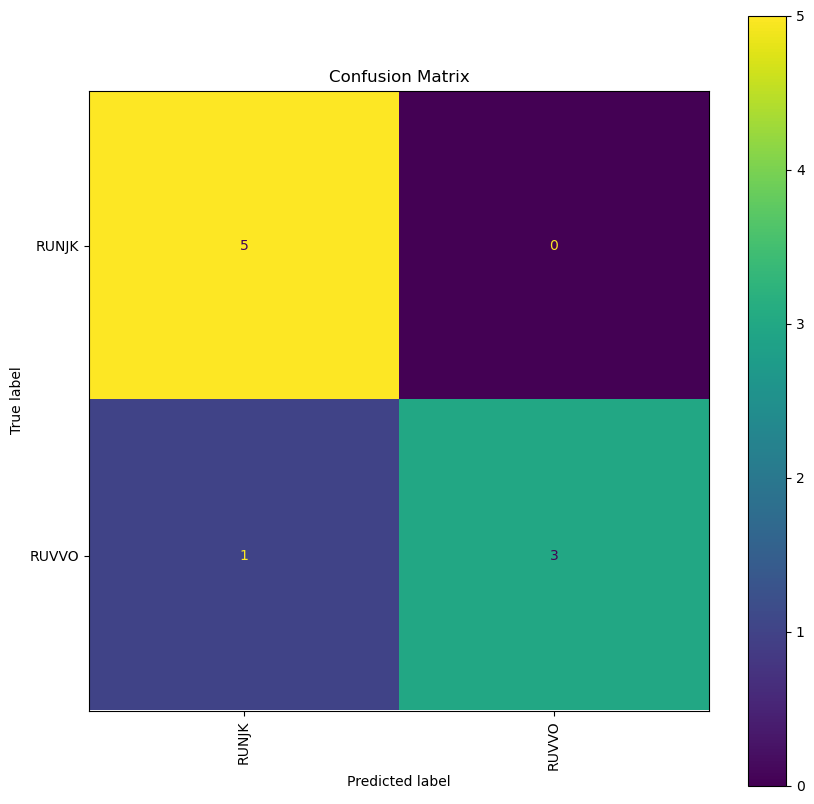

📊 [교차검증 결과]
Accuracy (Train): 1.0000
Accuracy (Test): 0.8889
CV Accuracy Mean: 0.8143 ± 0.1895
CV F1 Macro: 0.8102
CV Precision Macro: 0.8350
⚠️ 과적합 의심: 학습/테스트 정확도 차이 0.1111

📄 [Classification Report]
              precision    recall  f1-score   support

       RUNJK       0.83      1.00      0.91         5
       RUVVO       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9



In [7]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils import resample

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded

# ===== 4. 오버샘플링 적용 =====
max_count = df_5h["label"].value_counts().max()
resampled = []

for label in df_5h["label"].unique():
    subset = df_5h[df_5h["label"] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    resampled.append(upsampled)

df_balanced = pd.concat(resampled)

# ===== 5. 학습/테스트 분리 =====
X_bal = df_balanced[features]
y_bal = df_balanced["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

np.save("datasets/X_train_cluster7.npy", X_train)
np.save("datasets/X_test_cluster7.npy", X_test)
np.save("datasets/y_train_cluster7.npy", y_train)
np.save("datasets/y_test_cluster7.npy", y_test)

# ===== 6. 모델 정의 및 학습 (과적합 방지 설정) =====
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=14,  # ← 살짝만 더 깊게
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=120,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,              # ← 분할 더 열어줌
    scale_pos_weight=1.3,   # ← RUVVO recall 강화
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

# ===== 7. 평가 =====
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== 1. 교차검증 정확도 =====
acc_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='precision_macro')

# ===== 2. 학습/테스트 정확도 =====
train_score = voting_clf.score(X_train, y_train)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 3. 예측 및 리포트 =====
y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 4. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 5. 결과 출력 =====
print("📊 [교차검증 결과]")
print(f"Accuracy (Train): {train_score:.4f}")
print(f"Accuracy (Test): {test_score:.4f}")
print(f"CV Accuracy Mean: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV F1 Macro: {f1_scores.mean():.4f}")
print(f"CV Precision Macro: {prec_scores.mean():.4f}")
if gap > 0.1:
    print(f"⚠️ 과적합 의심: 학습/테스트 정확도 차이 {gap:.4f}")
else:
    print("✅ 과적합 위험 없음")

print("\n📄 [Classification Report]")
print(report)

In [9]:
# 오버샘플링된 레이블 → 항구명으로 다시 복원
df_balanced["PORT_NAME"] = le.inverse_transform(df_balanced["label"])

# 항구별 데이터 개수 출력
print("\n🛳️ [오버샘플링된 항구별 샘플 개수]")
print(df_balanced["PORT_NAME"].value_counts())


🛳️ [오버샘플링된 항구별 샘플 개수]
PORT_NAME
RUVVO    21
RUNJK    21
Name: count, dtype: int64


In [43]:
import joblib
import os

# Voting Classifier 저장
joblib.dump(voting_clf, "model/port_model_7.joblib")

# LabelEncoder 저장
joblib.dump(le, "model/encoder_7.joblib")

print("✅ 모델과 인코더 저장 완료!")

✅ 모델과 인코더 저장 완료!


## Train/Test 분리 후 오버샘플링을 적용한 Soft Voting

In [14]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils import resample

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 4. 훈련/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 5. 오버샘플링 (훈련 데이터에만 적용) =====
train_df = pd.DataFrame(X_train, columns=features)
train_df["label"] = y_train

max_count = train_df["label"].value_counts().max()
resampled = []
for label in train_df["label"].unique():
    subset = train_df[train_df["label"] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    resampled.append(upsampled)

train_balanced = pd.concat(resampled)
X_train_bal = train_balanced[features]
y_train_bal = train_balanced["label"]

# ===== 6. 모델 정의 =====
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False,
                    eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

# ===== 7. 학습 및 평가 =====
voting_clf.fit(X_train_bal, y_train_bal)
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sk

In [30]:
!pip install imbalanced-learn

## SMOTE 오버샘플링 + Soft voting

In [16]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # 🔥 핵심
import warnings
warnings.filterwarnings("ignore")

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 4. 훈련/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 5. SMOTE 오버샘플링 적용 (훈련셋에만) =====
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ===== 6. 모델 정의 =====
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False,
                    eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

# ===== 7. 학습 및 평가 =====
voting_clf.fit(X_train_smote, y_train_smote)
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.75      0.75      0.75         4

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5



# LSTM